# Fine-tuning transformer

### Getting the data

#### Train/test data

In [1]:
!mkdir data
!mkdir data/history
!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1iqg1FIPfbrZWlung6gZqve1MeQWc0Je4&export=download&authuser=1&confirm=t' -O './data/dataset.csv'

import pandas as pd

df = pd.read_csv('./data/dataset.csv')
df.info()

--2024-12-18 11:50:24--  https://drive.usercontent.google.com/download?id=1iqg1FIPfbrZWlung6gZqve1MeQWc0Je4&export=download&authuser=1&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.126.132, 2607:f8b0:4001:c10::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.126.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218678075 (209M) [application/octet-stream]
Saving to: './data/dataset.csv'

./data/dataset.csv  100%[===================>] 208.55M   236MB/s    in 0.9s    

2024-12-18 11:50:27 (236 MB/s) - './data/dataset.csv' saved [218678075/218678075]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22224 entries, 0 to 22223
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               22224 non-null  object 
 1   location                      

### Extra dependencies

In [2]:
%pip install -U sentence-transformers -qqq

Note: you may need to restart the kernel to use updated packages.


### Service functions

In [3]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import gc
import re
import os
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from numba import cuda


os.environ["WANDB_DISABLED"] = "true"


def memory_cleanup():
    "Clean up memory"
    gc.collect()
    torch.cuda.empty_cache()


def get_sentence_lengths(text):
    "Get number of words in each sentence in the text"
    pattern = r'(?<=[.!?])'
    sentences = re.split(pattern, text)
    
    # remove empty strings
    sentences = [sentence for sentence in sentences if len(sentence) > 0]
    
    # get number of words in each sentence
    sentence_lengths = [len(sentence.split()) for sentence in sentences]
    
    return sentences, sentence_lengths


def set_seed(seed: int) -> None:
    "Set seed for reproducibility"
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def train_tsdae_bert(model_name, train_sentences):
    """Train a denoising auto-encoder model with BERT model.
    more examples at https://sbert.net/examples/unsupervised_learning/TSDAE/README.html"""
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "cls")
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # Create the special denoising dataset that adds noise on-the-fly
    train_dataset = datasets.DenoisingAutoEncoderDataset(train_sentences)
    
    # DataLoader to batch your data
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    # Use the denoising auto-encoder loss
    train_loss = losses.DenoisingAutoEncoderLoss(
        model, decoder_name_or_path=model_name, tie_encoder_decoder=True,
    )
    
    # Call the fit method
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=1,
        weight_decay=0,
        scheduler="constantlr",
        optimizer_params={"lr": 3e-5},
        show_progress_bar=True,
    )
    
    return model

Display model output

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t


def display_metrics_with_ci(history: dict):
    # plot mean and ci for train and test r2 for all seeds and all iterations, averaged over seeds
    seeds = list(history.keys())
    def mean_confidence_interval(data, confidence=0.95):
        n = len(data)
        m, se = np.mean(data), np.std(data) / np.sqrt(n)
        h = se * t.ppf((1 + confidence) / 2, n-1)
        return m, m-h, m+h

    r2_train_values = [history[seed]['train_r2'] for seed in seeds]
    r2_test_values = [history[seed]['test_r2'] for seed in seeds]

    r2_train_values = np.array(r2_train_values)
    r2_test_values = np.array(r2_test_values)

    r2_train_mean = np.mean(r2_train_values, axis=0)
    r2_test_mean = np.mean(r2_test_values, axis=0)

    r2_train_ci = np.array([mean_confidence_interval(r2_train_values[:, i]) for i in range(r2_train_values.shape[1])])
    r2_test_ci = np.array([mean_confidence_interval(r2_test_values[:, i]) for i in range(r2_test_values.shape[1])])

    plt.figure(figsize=(10, 6))
    plt.plot(r2_train_mean[1:], label='train')
    plt.fill_between(range(len(r2_train_mean[1:])), r2_train_ci[1:, 1], r2_train_ci[1:, 2], alpha=0.3)

    plt.plot(r2_test_mean[1:], label='test')
    plt.fill_between(range(len(r2_test_mean[1:])), r2_test_ci[1:, 1], r2_test_ci[1:, 2], alpha=0.3)
    plt.title('Mean R2 by epoch, with 95% CI')
    plt.xlabel('Epoch')
    plt.ylabel('R2')
    plt.legend()
    plt.show()

    mae_test_values = [history[seed]['test_mae'] for seed in seeds]
    rmse_test_values = [history[seed]['test_rmse'] for seed in seeds]

    mae_test_values = np.array(mae_test_values)
    rmse_test_values = np.array(rmse_test_values)

    mae_test_mean = np.mean(mae_test_values, axis=0)
    rmse_test_mean = np.mean(rmse_test_values, axis=0)

    mae_test_ci = np.array([mean_confidence_interval(mae_test_values[:, i]) for i in range(mae_test_values.shape[1])])
    rmse_test_ci = np.array([mean_confidence_interval(rmse_test_values[:, i]) for i in range(rmse_test_values.shape[1])])

    # get an index of the epoch, where the test R2 is the highest
    # get mean and CI for this epoch
    best_epoch = np.argmax(r2_test_mean)
    best_epoch_r2 = r2_test_mean[best_epoch]
    best_epoch_mae = mae_test_mean[best_epoch]
    best_epoch_rmse = rmse_test_mean[best_epoch]
    best_epoch_r2_ci = r2_test_ci[best_epoch]
    best_epoch_mae_ci = mae_test_ci[best_epoch]
    best_epoch_rmse_ci = rmse_test_ci[best_epoch]

    print(f'TEST METRICS FOR THE BEST EPOCH (#{best_epoch+1})')
    print(f'R2: mean = {best_epoch_r2:.4f}, 95% CI = [{best_epoch_r2_ci[1]:.4f}, {best_epoch_r2_ci[2]:.4f}]')
    print(f'MAE: mean = {best_epoch_mae:.4f}, 95% CI = [{best_epoch_mae_ci[1]:.4f}, {best_epoch_mae_ci[2]:.4f}]')
    print(f'RMSE: mean = {best_epoch_rmse:.4f}, 95% CI = [{best_epoch_rmse_ci[1]:.4f}, {best_epoch_rmse_ci[2]:.4f}]')

### Traning-related classes

#### Dataset

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# Dataset for dual textual features
class DualTextDataset(Dataset):
    def __init__(self, df, text_col_1, text_col_2, targets, tokenizer, max_len):
        print('Creating the dataset...')
        # Pre-tokenize and store inputs
        self.tokenized_texts1 = tokenizer(df[text_col_1].tolist(), max_length=max_len, padding="max_length", truncation=True, return_tensors="pt")
        self.tokenized_texts2 = tokenizer(df[text_col_2].tolist(), max_length=max_len, padding="max_length", truncation=True, return_tensors="pt")
        self.targets = targets.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        # Return only the slice for idx
        inputs1 = {key: val[idx] for key, val in self.tokenized_texts1.items()}
        inputs2 = {key: val[idx] for key, val in self.tokenized_texts2.items()}
        target = torch.tensor(self.targets[idx], dtype=torch.float)
        return inputs1, inputs2, target


#### Model

##### Single-head BERT with MLP

In [7]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer


# single bert for two text features with MLP head for regression
class SingleBERTWithMLP(nn.Module):
    def __init__(self, config):
        super(SingleBERTWithMLP, self).__init__()
        model_name = config["model_name"]
        # Initialize a single BERT model
        self.bert = AutoModel.from_pretrained(model_name)

        # Define MLP head
        hidden_size = self.bert.config.hidden_size
        mlp_hidden_size = config["mlp_hidden_size"]
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_size, mlp_hidden_size),  # Double hidden size for concatenation
            nn.ReLU(),
            nn.Linear(mlp_hidden_size, 1)  # Regression output
        )

    def forward(self, input1, attention_mask1, input2, attention_mask2):
        # Pass both inputs through the same BERT model
        cls1 = self.bert(input_ids=input1, attention_mask=attention_mask1).last_hidden_state[:, 0, :]  # CLS token for input1
        cls2 = self.bert(input_ids=input2, attention_mask=attention_mask2).last_hidden_state[:, 0, :]  # CLS token for input2

        # Concatenate CLS embeddings
        combined_cls = torch.cat([cls1, cls2], dim=-1)  # Shape: [batch_size, 2 * hidden_size]

        # Pass through MLP head
        output = self.mlp(combined_cls)
        return output


#### Training methods

In [12]:
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


def fit_eval(
    seed,
    model,
    X_train,
    X_test,
    y_train_reg,
    y_test_reg,
    criterion,
    tokenizer,
    config,
    text_col_1,
    text_col_2,
):
    set_seed(seed)
    
    # Memory cleanup
    memory_cleanup()

    # Unpack config
    learning_rate = config["learning_rate"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    seq_length = config["seq_length"]

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Make datasets
    train_dataset = DualTextDataset(X_train, text_col_1, text_col_2, y_train_reg, tokenizer, seq_length)
    test_dataset = DualTextDataset(X_test, text_col_1, text_col_2, y_test_reg, tokenizer, seq_length)
    # Make dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training and Evaluation Loop
    history = {
                "train_loss": [],
               "test_loss": [], 
                "train_rmse": [],
               "test_rmse": [], 
               "train_r2": [],
               "train_r2": [],
               "test_r2": [],
               "train_mae": [],
               "test_mae": [],
               "y_pred": [],
               "y_test": [],
               }

    print('Starting training/eval loop...')
    for epoch in range(num_epochs):
        print('Starting training...')
        # Training Phase
        model.train()
        train_losses = []
        all_preds = []
        all_labels = []
        for batch in train_dataloader:
            inputs1, inputs2, targets = batch
            input1 = inputs1["input_ids"].squeeze(1).to(device)
            attention_mask1 = inputs1["attention_mask"].squeeze(1).to(device)
            input2 = inputs2["input_ids"].squeeze(1).to(device)
            attention_mask2 = inputs2["attention_mask"].squeeze(1).to(device)
            targets = targets.to(device)
    
            optimizer.zero_grad()
            outputs = model(input1, attention_mask1, input2, attention_mask2)
            outputs = outputs.flatten()

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            all_preds.extend(outputs.cpu().detach().numpy())
            all_labels.extend(targets.cpu().numpy())
    
        train_loss = np.mean(train_losses)
        
        train_r2 = r2_score(all_labels, all_preds)

        train_rmse = mean_squared_error(all_labels, all_preds, squared=False)
        
        train_mae = mean_absolute_error(all_labels, all_preds)
        
        history["train_loss"].append(train_loss)
        history["train_r2"].append(train_r2)
        history["train_rmse"].append(train_rmse)
        history["train_mae"].append(train_mae)
    
        # Evaluation Phase
        print('Epoch done, evaluating...')
        model.eval()
        test_losses = []
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in test_dataloader:
                inputs1, inputs2, targets = batch
                input1 = inputs1["input_ids"].squeeze(1).to(device)
                attention_mask1 = inputs1["attention_mask"].squeeze(1).to(device)
                input2 = inputs2["input_ids"].squeeze(1).to(device)
                attention_mask2 = inputs2["attention_mask"].squeeze(1).to(device)
                targets = targets.to(device)

                outputs = model(input1, attention_mask1, input2, attention_mask2)
                outputs = outputs.flatten()

                loss = criterion(outputs, targets)
                test_losses.append(loss.item())

                all_preds.extend(outputs.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        history["y_pred"].append(all_preds)
        history["y_test"].append(all_labels)

        test_loss = np.mean(test_losses)

        test_r2 = r2_score(all_labels, all_preds)
        
        test_rmse = mean_squared_error(all_labels, all_preds, squared=False)
        
        test_mae = mean_absolute_error(all_labels, all_preds)
    
        history["test_loss"].append(test_loss)
        
        history["test_r2"].append(test_r2)
        
        history["test_rmse"].append(test_rmse)
        
        history["test_mae"].append(test_mae)
    
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")

        print(f"Epoch {epoch + 1}/{num_epochs}, Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

    return model, history

### Training-eval loop with experiments

#### Data preprocessing

##### Define text feature/target columns

In [14]:
text_col_1 = 'description_no_numbers'
text_col_1_with_prompt = text_col_1 + '_with_prompt' # Add prompt to text column

text_col_2 = 'title_company_location_skills_source' # Merged text column, second feature

target_col = 'log_salary_from' # regression target

##### Create merged title/skills/location/source feature

In [15]:
df['skills'] = df['skills'].fillna('Не указаны')

title_company_location_skills_feature_template = """
Позиция: {position}
Компания: {company}
Место: {location}
Навыки: {skills}
Источник: {source}
"""

df['title_company_location_skills_source'] = df.apply(lambda x: title_company_location_skills_feature_template.format(
    position=x['title'],
    company=x['company'],
    location=x['location'],
    skills=x['skills'],
    source=x['source']
), axis=1)

##### Add a prompt to the feature 1

In [ ]:
# prompt to be added to feature 1 for [MASK] token embedding regression
# (may be not used here)
prompt = """\
[CLS] Далее указано описание вакансии. \
Судя по описанию, зарплата на этой позиции составляет [MASK].[SEP]\
"""

df[text_col_1_with_prompt] = prompt + df[text_col_1]

#### Training code

In [17]:
memory_cleanup()

##### Experiment 3: Single BERT, Huber loss

SINGLE_BERT_HUBER



tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/732 [00:00<?, ?B/s]


Starting for seed 42...
----------------------------------------------------------------------------------------------------



config.json:   0%|          | 0.00/712 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

Creating the dataset...
Creating the dataset...
Starting training/eval loop...
Starting training...
Epoch done, evaluating...
Epoch 1/10, Train Loss: 1.0473, Test Loss: 0.1951, Train R2: -9.7552, Test R2: -0.0203
Epoch 1/10, Train MAE: 1.4232, Test MAE: 0.5219
Starting training...
Epoch done, evaluating...
Epoch 2/10, Train Loss: 0.1320, Test Loss: 0.1200, Train R2: 0.3222, Test R2: 0.3784
Epoch 2/10, Train MAE: 0.4122, Test MAE: 0.3901
Starting training...
Epoch done, evaluating...
Epoch 3/10, Train Loss: 0.0912, Test Loss: 0.1071, Train R2: 0.5346, Test R2: 0.4480
Epoch 3/10, Train MAE: 0.3353, Test MAE: 0.3658
Starting training...
Epoch done, evaluating...
Epoch 4/10, Train Loss: 0.0772, Test Loss: 0.0940, Train R2: 0.6068, Test R2: 0.5169
Epoch 4/10, Train MAE: 0.3072, Test MAE: 0.3413
Starting training...
Epoch done, evaluating...
Epoch 5/10, Train Loss: 0.0705, Test Loss: 0.0801, Train R2: 0.6411, Test R2: 0.5893
Epoch 5/10, Train MAE: 0.2924, Test MAE: 0.3125
Starting training..

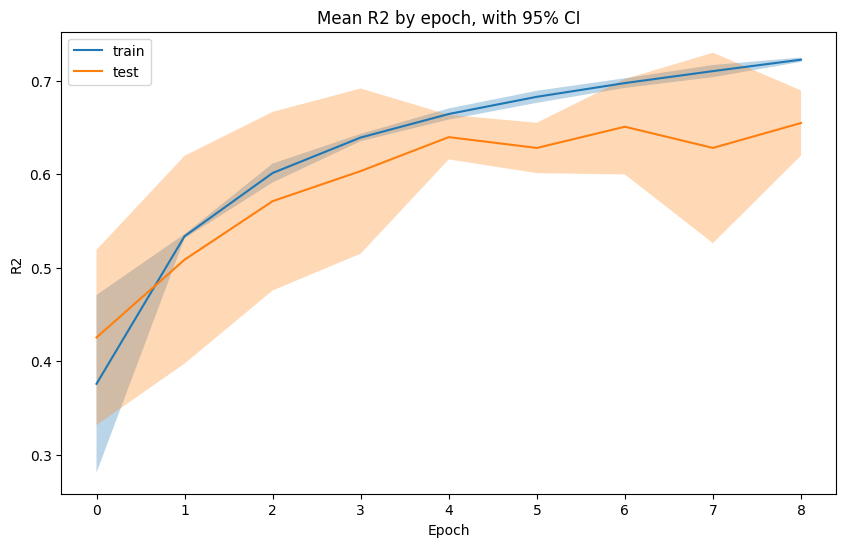

TEST METRICS FOR THE BEST EPOCH (#10)
R2: mean = 0.6546, 95% CI = [0.6198, 0.6894]
MAE: mean = 0.2856, 95% CI = [0.2692, 0.3019]
RMSE: mean = 0.3693, 95% CI = [0.3515, 0.3872]


In [20]:
import torch.nn as nn
import pickle
import warnings
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split


experiment_name = 'single_bert_huber'
print(experiment_name.upper())
print('='*100)
print()

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

seeds = [42, 78687, 123123]
combined_history = {}

# Hyperparameters and configuration
config = {
    "model_name": "sergeyzh/rubert-tiny-turbo",
    "batch_size": 32,
    "seq_length": 1024,
    "hidden_size": 312,
    "mlp_hidden_size": 128,
    "num_epochs": 10,
    "learning_rate": 5e-6,
}

memory_cleanup()

model_name = config['model_name']
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader
# Prepare data
X = df[[text_col_1, text_col_1_with_prompt, text_col_2]]
y = df[[target_col,]]

for seed in seeds:
    memory_cleanup()
    print()
    print(f'Starting for seed {str(seed)}...')
    print('-' * 100)
    print()

    combined_history[seed] = {}

    set_seed(seed)

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    y_train_reg = y_train[target_col]
    y_test_reg = y_test[target_col]

    # Initialize the model
    model = SingleBERTWithMLP(config)
    model = torch.nn.DataParallel(model).to(device)

    # Loss Function
    criterion = nn.HuberLoss() # changed!

    model, history = fit_eval(
        seed,
        model,
        X_train,
        X_test,
        y_train_reg,
        y_test_reg,
        criterion,
        tokenizer,
        config,
        text_col_1,
        text_col_2,
    )

    memory_cleanup()

    combined_history[seed] = history    

# Display metrics
display_metrics_with_ci(combined_history)

# save the history as pickle
with open(f'./data/history/transfomers_{experiment_name}.pickle', 'wb') as handle:
    pickle.dump(combined_history, handle, protocol=pickle.HIGHEST_PROTOCOL)